# Liver Model Construction: Notebook

In [1]:
import os
import re
import warnings
# from cobra.io import *
from cobra.io.json import load_json_model as load_json_cobra_model
import escher
import mass
import numpy as np
import pandas as pd
import equilibrator_api
from equilibrator_api import ComponentContribution, Q_
import sympy as sym
from cobra import Model, Reaction, Metabolite
import cobra.test
from os.path import join
from mass.util import qcqa
from mass.util import qcqa_model
from cobra import DictList
from mass import (
    MassConfiguration, MassMetabolite, MassModel,
    MassReaction, Simulation, UnitDefinition)
from mass.io.json import save_json_model as save_json_mass_model
from mass.visualization import plot_comparison, plot_time_profile
from mass.visualization import (
    plot_ensemble_phase_portrait, plot_ensemble_time_profile)
mass_config = MassConfiguration()
mass_config.irreversible_Keq = float("inf")
print("MASSpy version: {0}".format(mass.__version__))
from six import iteritems
import matplotlib.pyplot as plt
from mass.thermo import (
    ConcSolver, sample_concentrations,
    update_model_with_concentration_solution)
# from cobra.io.json import *
import cobra_dict as c_d
import csv
import altair as alt
from minspan.minspan import minspan,nnz
# from minspan import minspan,nnz

MASSpy version: 0.1.6


In [2]:
import sys
# from minspan import minspan,nnz
print(sys.version)

3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]


In [3]:
type(dict)

type

In [4]:
maps_dir = os.path.abspath("maps")
data_dir = os.path.abspath("data")
dir = os.path.abspath("")
model_dir = os.path.abspath("models")
minspan_dir= os.path.abspath("minspans_csv")
# extra_dir=os.path.abspath("..")
# minspan_dir

### Getting reactions and metabolite data from RECON 3D

In [5]:
# making dataframe of metabolites

csv_met = os.path.join(data_dir,"gly_met_df.csv")
met_csv_df = pd.read_csv(csv_met,index_col="id")
metabolite_info=met_csv_df.to_dict(orient='index')


### Loading cobra model

In [6]:
# Initiate empty model
trial= cobra.Model()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-07-02


In [7]:
#  Add all the remaining metabolites involved in the pathway
for met_id, info in metabolite_info.items():
    met = cobra.Metabolite(met_id, name=info['name'], formula=info['formula'], 
                           charge=info['charge'], compartment=info['compartment'])
    trial.add_metabolites(met)

In [8]:
import json

In [9]:
# Loading reaction data as JSON file to maintain data types as dictionaries 
rxn_json = os.path.join(data_dir,"gly_reaction_df.json")
with open(rxn_json) as json_file:
    rxn_data = json.load(json_file)

In [10]:
for reaction, info in rxn_data.items():
    reaction_obj = cobra.Reaction(reaction)
    reaction_obj.id=reaction
    reaction= reaction_obj.id
    reaction_obj.lower_bound = info['lower_bound']
    reaction_obj.upper_bound = info['upper_bound']
    reaction_obj.name = info['name']
    trial.add_reaction(reaction_obj)
    temp=info['metabolites']
    reaction_obj.add_metabolites(temp)
    print(reaction)

HEX1
PGI
FBP
PFK
FBA
TPI
GAPD
PGK
PGM
ENO
PYK
LDH_L
ATPM


In [11]:
nadhm = {'nadh_c': -1, 'h_c': 1, 'nad_c': 1}
rxn = cobra.Reaction('NADHM')
trial.add_reaction(rxn)
rxn.add_metabolites(nadhm)

In [12]:
#Mass balance check
for r in trial.reactions:
    print(r.id,  r.check_mass_balance())

HEX1 {'charge': -1.0}
PGI {}
FBP {'charge': 2.0}
PFK {'charge': -1.0}
FBA {}
TPI {}
GAPD {'charge': -3.0}
PGK {}
PGM {}
ENO {}
PYK {'charge': 1.0}
LDH_L {'charge': -1.0}
ATPM {'charge': 1.0}
NADHM {'charge': 1}


In [13]:
trial.metabolites.h_c.charge= 1
# trial.metabolites.h_e.charge= 1
trial.metabolites.pi_c.charge= -2

In [14]:
#Mass balance check
for r in trial.reactions:
    print(r.id,  r.check_mass_balance())

HEX1 {}
PGI {}
FBP {}
PFK {}
FBA {}
TPI {}
GAPD {}
PGK {}
PGM {}
ENO {}
PYK {}
LDH_L {}
ATPM {}
NADHM {'charge': 2}


In [15]:
for met in ['glc__D_c', 'h2o_c', 'h_c', 'pi_c','lac__L_c', "pyr_c"]:
    rxn = cobra.Reaction('EX_%s' % met)
    trial.add_reaction(rxn)
    rxn.add_metabolites({met: -1})
    if met == 'glc__D_c':
        rxn.lower_bound = -0.00104480 
        # by convention negative exchange flux = uptake
        # https://reader.elsevier.com/reader/sd/pii/S0306987799909581?token=41F1F439A88E2255F03BDDC4FC2EEF12EF4CE079DA368A4C45F0838E164FDA3C50D17264DCA8970E4152B30CBE36A5B1&originRegion=us-east-1&originCreation=20220420180454
    elif met == 'pyr_c':
        rxn.lower_bound = 0
    else:
        rxn.lower_bound = -1000

In [16]:
for reaction in trial.reactions:
    print(reaction)

HEX1: atp_c + glc__D_c --> adp_c + g6p_c + h_c
PGI: g6p_c <=> f6p_c
FBP: fdp_c + h2o_c --> f6p_c + pi_c
PFK: atp_c + f6p_c --> adp_c + fdp_c + h_c
FBA: fdp_c <=> dhap_c + g3p_c
TPI: dhap_c <=> g3p_c
GAPD: g3p_c + nad_c + pi_c <=> 13dpg_c + h_c + nadh_c
PGK: 3pg_c + atp_c <=> 13dpg_c + adp_c
PGM: 2pg_c <=> 3pg_c
ENO: 2pg_c <=> h2o_c + pep_c
PYK: adp_c + h_c + pep_c --> atp_c + pyr_c
LDH_L: lac__L_c + nad_c <=> h_c + nadh_c + pyr_c
ATPM: atp_c + h2o_c --> adp_c + h_c + pi_c
NADHM: nadh_c --> h_c + nad_c
EX_glc__D_c: glc__D_c <=> 
EX_h2o_c: h2o_c <=> 
EX_h_c: h_c <=> 
EX_pi_c: pi_c <=> 
EX_lac__L_c: lac__L_c <=> 
EX_pyr_c: pyr_c --> 


In [17]:
trial.objective = 'ATPM'
flux_solution = trial.optimize()
flux_solution

,fluxes,reduced_costs
HEX1,0.001045,0.0
PGI,0.001045,0.0
FBP,0.000000,-2.0
PFK,0.001045,0.0
FBA,0.001045,0.0
...,...,...
EX_h2o_c,0.000000,-0.0
EX_h_c,0.002090,0.0
EX_pi_c,0.000000,0.0
EX_lac__L_c,0.002090,0.0


In [18]:
#Escher FBA: shows the solutions on the map
initial_flux_data = {
    reaction: flux
    for reaction, flux in flux_solution.fluxes.items()}

#view all the reactions that we need build
escher_builder = escher.Builder(
    model=trial,
    map_json=os.path.join(
        maps_dir,"Glycolysis.json")
    , reaction_data=initial_flux_data)

# Display map in notebook
escher_builder

Builder(reaction_data={'HEX1': 0.0010448, 'PGI': 0.0010448, 'FBP': 0.0, 'PFK': 0.0010448, 'FBA': 0.0010448, 'T…

In [19]:
from cobra_dict import metabolite_to_dict as metabolite_to_dict
from cobra_dict import reaction_to_dict as reaction_to_dict

In [20]:
met_df=pd.DataFrame()
for met in trial.metabolites:
    cobra_met= trial.metabolites.get_by_id(met.id)
    m=metabolite_to_dict(cobra_met)
    df_2=pd.DataFrame.from_dict(m,orient='index')
    df_2=df_2.T
    # met_df=met_df.append(df_2)
    met_df = pd.concat([met_df, df_2])
met_df=met_df.set_index('id')

In [21]:
met_df

,name,charge,formula,compartment
id,,,,
adp_c,ADP C10H12N5O10P2,-3,C10H12N5O10P2,c
atp_c,ATP C10H12N5O13P3,-4,C10H12N5O13P3,c
g6p_c,D-Glucose 6-phosphate,-2,C6H11O9P,c
glc__D_c,D-Glucose,0,C6H12O6,c
h_c,H+,1,H,c
f6p_c,D-Fructose 6-phosphate,-2,C6H11O9P,c
fdp_c,"D-Fructose 1,6-bisphosphate",-4,C6H10O12P2,c
h2o_c,H2O H2O,0,H2O,c
pi_c,Phosphate,-2,HO4P,c


In [22]:
csv_met_cobra = os.path.join(data_dir,"gly_cobra_met.csv")
met_df.to_csv(csv_met_cobra)

In [23]:
rxn_df=pd.DataFrame()
for rxn in trial.reactions:
    cobra_rxn= trial.reactions.get_by_id(rxn.id)
    r=reaction_to_dict(cobra_rxn)
#     print(r)
    df=pd.DataFrame.from_dict(r,orient='index')
    df=df.T
    # rxn_df=rxn_df.append(df)
    rxn_df = pd.concat([rxn_df, df])

rxn_df=rxn_df.set_index('id')

In [24]:
rxn_df

,name,metabolites,lower_bound,upper_bound,gene_reaction_rule,objective_coefficient
id,,,,,,
HEX1,Hexokinase (D-glucose:ATP),"{'adp_c': 1.0, 'atp_c': -1.0, 'g6p_c': 1.0, 'g...",0.0,1000.0,,NaN
PGI,Glucose-6-phosphate isomerase,"{'f6p_c': 1.0, 'g6p_c': -1.0}",-1000.0,1000.0,,NaN
FBP,Fructose-bisphosphatase,"{'f6p_c': 1.0, 'fdp_c': -1.0, 'h2o_c': -1.0, '...",0.0,1000.0,,NaN
PFK,Phosphofructokinase,"{'adp_c': 1.0, 'atp_c': -1.0, 'f6p_c': -1.0, '...",0.0,1000.0,,NaN
FBA,Fructose-bisphosphate aldolase,"{'dhap_c': 1.0, 'fdp_c': -1.0, 'g3p_c': 1.0}",-1000.0,1000.0,,NaN
TPI,Triose-phosphate isomerase,"{'dhap_c': -1.0, 'g3p_c': 1.0}",-1000.0,1000.0,,NaN
GAPD,Glyceraldehyde-3-phosphate dehydrogenase,"{'13dpg_c': 1.0, 'g3p_c': -1.0, 'h_c': 1.0, 'n...",-1000.0,1000.0,,NaN
PGK,Phosphoglycerate kinase,"{'13dpg_c': 1.0, '3pg_c': -1.0, 'adp_c': 1.0, ...",-1000.0,1000.0,,NaN
PGM,Phosphoglycerate mutase,"{'2pg_c': -1.0, '3pg_c': 1.0}",-1000.0,1000.0,,NaN


In [25]:
json_rxn_cobra = os.path.join(data_dir,"gly_cobra_rxn.json")
rxn_df.to_json(json_rxn_cobra
,orient="index")

## Making MASS model of glycolysis

In [26]:
liver= MassModel("Core_Model", array_type='DataFrame', dtype=np.int64)

#### Add the pathway metabolites and their information to a new MASS model

In [27]:
import json

In [28]:
met_csv_df = pd.read_csv(csv_met_cobra,index_col="id")
mass_metabolite_info=met_csv_df.to_dict(orient='index')

# Loading reaction data as JSON file to maintain data types as dictionaries 

with open(json_rxn_cobra) as json_file:
    mass_rxn_data = json.load(json_file)

In [29]:
for met_id, info in mass_metabolite_info.items():
    met = MassMetabolite(met_id, name=info['name'], formula=info['formula'], 
                           charge=info['charge'], compartment=info['compartment'])
    liver.add_metabolites(met)

In [30]:
for reaction, info in mass_rxn_data.items():
    reaction_obj = MassReaction(reaction)
    reaction_obj.id = reaction
    reaction= reaction_obj.id
    reaction_obj.lower_bound = info['lower_bound']
    reaction_obj.upper_bound = info['upper_bound']
    reaction_obj.name = info['name']
#     if reaction_obj.id != "DM_nadh" or reaction_obj.id != 'ATPM':
    liver.add_reactions(reaction_obj)
    temp=info['metabolites']
    reaction_obj.add_metabolites(temp)
    # print(reaction)

In [31]:
liver.reactions.PGK.reverse_stoichiometry(inplace=True)
liver.reactions.PGM.reverse_stoichiometry(inplace=True)
# liver.reactions.PGM

Reaction identifier,PGM
Name,Phosphoglycerate mutase
Memory address,0x02723b524070
Subsystem,
Kinetic Reversibility,True
Stoichiometry,3pg_c <=> 2pg_c 3-Phospho-D-glycerate <=> D-Glycerate 2-phosphate
GPR,
Bounds,"(-1000.0, 1000.0)"


##  Set Fluxes

In [32]:
fluxes_mass = flux_solution.to_frame()
fluxes_mass

,fluxes,reduced_costs
HEX1,0.001045,0.0
PGI,0.001045,0.0
FBP,0.000000,-2.0
PFK,0.001045,0.0
FBA,0.001045,0.0
TPI,0.001045,0.0
GAPD,0.002090,0.0
PGK,-0.002090,-0.0
PGM,-0.002090,-0.0
ENO,0.002090,0.0


In [33]:
no_flux =[]
for r in liver.reactions:
    if r.id in fluxes_mass.index:
        flux =  fluxes_mass.loc[r.id,"fluxes"]
        # reaction = liver.reactions.get_by_id
        r.steady_state_flux = flux
        print(r.id, r.steady_state_flux)
        
    else:
        no_flux.append(r.id)

no_flux

HEX1 0.0010448
PGI 0.0010448
FBP 0.0
PFK 0.0010448
FBA 0.0010448
TPI 0.0010448
GAPD 0.0020896
PGK -0.0020896
PGM -0.0020896
ENO 0.0020896
PYK 0.0020896
LDH_L -0.0020896
ATPM 0.0020896
NADHM 0.0
EX_glc__D_c -0.0010448
EX_h2o_c 0.0
EX_h_c 0.0020896
EX_pi_c 0.0
EX_lac__L_c 0.0020896
EX_pyr_c 0.0


[]

## Setting initial conditions

In [34]:
import csv
import openpyxl

In [35]:
#Function to load data from the excel sheet
def load_data(filepath, sheet_name):
    """Load Liver data from an excel sheet"""
    df = pd.read_excel(engine='openpyxl',
        io=filepath,
        sheet_name=sheet_name,
        index_col=0)
    return df

In [36]:
#Compare Results
excel_ic = os.path.join(data_dir,"Concentrations2.xlsx")
ic_info_all = load_data(
    filepath=excel_ic,
    sheet_name="Concentrations")
ic_info_all.reset_index(level='ID', col_level=1, inplace=True)

In [37]:
conc_df =pd.DataFrame(ic_info_all.loc[:,["ID","Concentration (M)"]])
conc_df.set_index('ID',drop=True,inplace=True)

In [38]:
print("Initial Conditions\n------------------")

for met in liver.metabolites:
    #Setting inital condition of metabolties from HEPATOKIN  #M 
    if met.id in conc_df.index:
        mid=met.id
        # print(mid)
        # metabolite = reaction.metabolites
        ic_value = conc_df.loc[mid,'Concentration (M)']
        # print(mid,ic_value)
        met.ic =  (ic_value)            
for metabolite, ic_value in liver.initial_conditions.items():
    print("{0}: {1}".format(metabolite, ic_value))

Initial Conditions
------------------
adp_c: 0.00199495195
atp_c: 0.004727145980000001
g6p_c: 0.00014000000000000001
glc__D_c: 0.01048280703
f6p_c: 0.00012713765
fdp_c: 5.1470825e-05
pi_c: 0.0064
dhap_c: 0.00017689737
g3p_c: 8.783869999999999e-06
13dpg_c: 2.43e-07
nad_c: 0.00182530972
nadh_c: 4.63542e-06
3pg_c: 0.000520630485
2pg_c: 0.000110560855
pep_c: 0.00031
pyr_c: 0.00047999999999999996
lac__L_c: 0.00326183772


### Getting Standard and Physiological Gibbs energies of reactions

In [39]:
reaction_str= []

cc = ComponentContribution()

# optional: changing the aqueous environment parameters
cc.p_h = Q_(7.4)
cc.p_mg = Q_(3.31)
cc.ionic_strength = Q_("0.144M")
cc.temperature = Q_("310.15K")
R = 0.00831446261815324 #R = 0.00831446261815324 kJ/mol
from numpy import exp as exp


In [40]:
# Reactions that we don't want to get Keq from equilibrator [exchanges and psuedoreactions] SET THESE MANUALLY
# Setting Keq and kf for boundary reactions

excluded_reactions=["ATPM", 
# "NADHM",
]

In [41]:
print("Boundary Reactions and Values\n-----------------------------")
for reaction in liver.boundary:
    excluded_reactions.append(reaction.id)
    reaction.Keq=1    # Setting Keq
    reaction.kf=1e6     # Setting kf
    #Setting boundary condition metabolties from ic of metabolite from HEPATOKIN   
    for met in reaction.reactants:
        if met.id in conc_df.index:
            mid=met.id
            boundary_met = reaction.boundary_metabolite
            bcvalue = conc_df.loc[mid,'Concentration (M)']
            liver.boundary_conditions[boundary_met] =  bcvalue
            bc_value = liver.boundary_conditions.get(boundary_met)
            print("{0}\n{1}: {2}\n".format(reaction, boundary_met, bc_value))

# Trying to set these as 1e6 becasue the inf might be messing with the solver
liver.reactions.ATPM.Keq=1e6
liver.reactions.NADHM.Keq=1e6

Boundary Reactions and Values
-----------------------------
EX_glc__D_c: glc__D_c <=> 
glc__D_b: 0.01048280703

EX_pi_c: pi_c <=> 
pi_b: 0.0064

EX_lac__L_c: lac__L_c <=> 
lac__L_b: 0.00326183772

EX_pyr_c: pyr_c <=> 
pyr_b: 0.00047999999999999996



In [42]:
# Getting Keq from equilibrator by forming a reaction string that it can parse through
for reaction in liver.reactions:
    if reaction.id not in excluded_reactions:
        reactants = []
        #forming reaction string 
        for met in reaction.reactants:
            id_coeff= reaction.get_coefficient(met)
            new_id = met.id.rpartition("_" + str(met.compartment))[0] #removing compartment lettes, for eg "_c"
            if id_coeff == 1 or id_coeff == -1:
                new_id = "bigg.metabolite:" + new_id
            else:
                new_id = str(id_coeff) + " bigg.metabolite:" + new_id

            reactants.append(new_id)   
        reactants_string= " + ".join(reactants)
        reactants_string = str(reactants_string + " = ")

        # Forming product string
        products = []
        for met in reaction.products:
            new_id = met.id.rpartition("_" + str(met.compartment))[0] # removing compartment lettes, for eg "_c"
            new_id = "bigg.metabolite:" + new_id
            products.append(new_id)   
        products_string= " + ".join(products)

        #final reaction to parse
        reaction_to_parse = reactants_string + products_string         
        rxn_parsed = cc.parse_reaction_formula(reaction_to_parse)
        print(reaction.id)

        #Getting Gibbs energies
        dG0_prime = cc.standard_dg_prime(rxn_parsed)
        dGm_prime = cc.physiological_dg_prime(rxn_parsed)
        dG_prime_value_in_kj_per_mol = dGm_prime.value.m_as("kJ/mol")
        dG0prime_value_in_kj_per_mol = dG0_prime.value.m_as("kJ/mol")
        delG = dG_prime_value_in_kj_per_mol

        # Calculating Keq from delG
        a = exp(-delG/ (R*310.15)) 
        reaction.Keq = a
        print(f"Keq = {a}")    

HEX1
Keq = 4959.419292148073
PGI
Keq = 0.34798040939490554
FBP
Keq = 115004.76795942851
PFK
Keq = 1454.9063091036724
FBA
Keq = 0.1620181301040788
TPI
Keq = 0.11365701527311964
GAPD
Keq = 0.0006723795415727605
PGK
Keq = 1943.5298920087905
PGM
Keq = 0.17239894103513229
ENO
Keq = 4.332330471156045
PYK
Keq = 10333.2896179346
LDH_L
Keq = 0.00013815091719569572
NADHM
Keq = 225587875156.06818


In [43]:
liver.reactions.NADHM

Reaction identifier,NADHM
Name,
Memory address,0x025c989dfdc0
Subsystem,
Kinetic Reversibility,True
Stoichiometry,nadh_c <=> h_c + nad_c Nicotinamide adenine dinucleotide - reduced <=> H+ + Nicotinamide adenine dinucleotide
GPR,
Bounds,"(0.0, 1000.0)"


In [44]:
liver.metabolites.h_c.charge= 1
# liver.metabolites.h_e.charge= 1
liver.metabolites.pi_c.charge= -2

In [45]:
metabolite_ids = [m.id for m in liver.metabolites]
misbalance= pd.DataFrame(
    liver.S.dot(np.array(list(liver.steady_state_fluxes.values()))),
    index=metabolite_ids,
    columns=[r"$\textbf{Sv}_{\mathrm{stst}}$"])
misbalance.T

,adp_c,atp_c,g6p_c,glc__D_c,h_c,f6p_c,fdp_c,h2o_c,pi_c,dhap_c,g3p_c,13dpg_c,nad_c,nadh_c,3pg_c,2pg_c,pep_c,pyr_c,lac__L_c
$\textbf{Sv}_{\mathrm{stst}}$,0.004179,-0.004179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004179,0.0,0.0,0.0,-0.004179,0.0,0.0,0.0


## Setting initial conditions

In [46]:
# import csv
# csv_ic = os.path.join(data_dir,"Concentrations_Glycolysis.csv")
# # opening the CSV file
# with open(csv_ic, mode ='r')as file:
   
#   # reading the CSV file
#     csvFile = csv.reader(file)

#       # displaying the contents of the CSV file
#     for name, value in csvFile:
#         met_id = liver.metabolites.get_by_id(name)
#         met_id.ic = float(value) #M
#         print(met_id, ":", met_id.ic)

## Set H2O/H Constants

In [47]:
# Set concentrations of hydrogen, water as fixed
# Assume hydrogen in all compartments are fixed 
for metabolite in [
    "h_c",
#     'h_e','h_m',
#     'h2o_r','h2o_e',
    "h2o_c",
#     "glc__D_e", "pi_e",'pi_m',
    'pi_c'
                  ]:
    metabolite = liver.metabolites.get_by_id(metabolite)
    metabolite.fixed = True

In [48]:
for metabolite in [
#     'h_m',
"h_c", 
#     'h_e',
"h2o_c",
#     'h2o_r','h2o_e' 
]:
    metabolite = liver.metabolites.get_by_id(metabolite)
    metabolite.ic = 1 #M

In [49]:
for metabolite in liver.metabolites:
    print("{0}: {1}".format(metabolite.id, metabolite.ic))

adp_c: 0.00199495195
atp_c: 0.004727145980000001
g6p_c: 0.00014000000000000001
glc__D_c: 0.01048280703
h_c: 1
f6p_c: 0.00012713765
fdp_c: 5.1470825e-05
h2o_c: 1
pi_c: 0.0064
dhap_c: 0.00017689737
g3p_c: 8.783869999999999e-06
13dpg_c: 2.43e-07
nad_c: 0.00182530972
nadh_c: 4.63542e-06
3pg_c: 0.000520630485
2pg_c: 0.000110560855
pep_c: 0.00031
pyr_c: 0.00047999999999999996
lac__L_c: 0.00326183772


In [50]:
#Formulate QP minimization list for concentrations
conc_solver = ConcSolver(
    liver, 
    excluded_metabolites=[
    "h_c",
#         'h_e', 'h_m',
#     'h2o_r','h2o_e',
        "h2o_c",
#     "pi_e",
#     "glc__D_e", "lac__L_e",
#     "pyr_e"
    ], 
#     excluded_reactions=["Ht", "H2Ot", "H2Oter",'PIter','PIt',
#     'G6Pter','GLCter','GLCt1','PYRt2m','PEPtm',
#     'L_LACt2r','PYRt2'],

    constraint_buffer=1)

conc_solver.setup_feasible_qp_problem(
fixed_conc_bounds=list(liver.fixed))
# fixed_Keq_bounds=liver.reactions.list_attr("Keq_str")
    
#assumption: provide uncertainity to allow for a variance for the Keqs rather than staying fixed
conc_solver.setup_feasible_qp_problem(Keq_percent_deviation=0.1)

conc_solution = conc_solver.optimize()
conc_solution

['FBP', 'NADHM']
['FBP', 'NADHM']
mass\util\util.py:159 UserWarning: Unrecognized kwargs: ['Keq_percent_deviation']
mass\thermo\conc_solution.py:98 FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
mass\thermo\conc_solution.py:99 FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,variables,reduced_costs
adp_c,0.001995,0.0
atp_c,0.004727,0.0
g6p_c,0.000269,0.0
glc__D_c,0.010483,0.0
f6p_c,0.000066,0.0
...,...,...
Keq_PGM,0.137497,0.0
Keq_ENO,4.850113,0.0
Keq_PYK,10333.289618,0.0
Keq_LDH_L,0.000101,0.0


In [51]:
#Function to load data from the excel sheet
def load_data(filepath, sheet_name):
    """Load Liver data from an excel sheet"""
    df = pd.read_excel(engine='openpyxl',
        io=filepath,
        sheet_name=sheet_name,
        index_col=0)
    return df

In [52]:
#Compare Results
csv_ic = os.path.join(data_dir,"Concentrations_Glycolysis.xlsx")
# ic_df = pd.read_csv(csv_ic)
# ic_df.set_index()
ic_info = load_data(
    filepath=csv_ic,
    sheet_name="Concentrations")

mass\visualization\visualization_util.py:1202 UserWarning: Ignoring {'_2pg_c', '_3pg_c'}, only in one set of given values


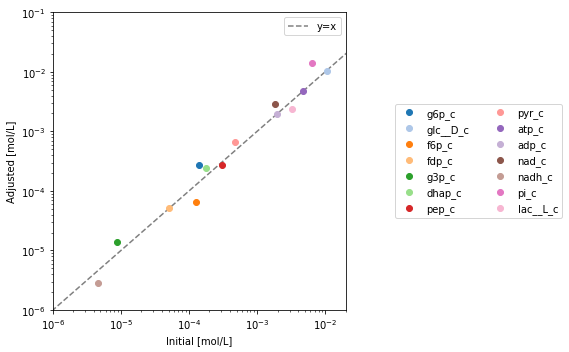

In [53]:
conc_comparison_fig, ax = plt.subplots(nrows=1, ncols=1,
                                       figsize=(5, 5))

plot_comparison(
    x=ic_info["Concentrations in M"], y=conc_solution,
    compare="concentrations",
    observable=[mid for mid in ic_info.index], ax=ax,
    legend="right outside", plot_function="loglog",
    xlim=(1e-6,0.02), ylim=(1e-6,1e-1),
    xy_line=True,
    xy_legend="best", xlabel="Initial [mol/L]", ylabel="Adjusted [mol/L]")

conc_comparison_fig.tight_layout()
update_model_with_concentration_solution(
    liver, conc_solution, concentrations=True, inplace=True);

In [54]:
update_model_with_concentration_solution(
    liver, conc_solution, concentrations=True, inplace=True)

Name,Core_Model
Memory address,0x025c989ab520
Stoichiometric Matrix,19x20
Matrix Rank,17
Number of metabolites,19
Initial conditions defined,19/19
Number of reactions,20
Number of genes,0
Number of enzyme modules,0
Number of groups,0
Objective expression,0


In [55]:
seed = int(1)
n_models = 500

In [56]:
conc_solver.setup_sampling_problem(
    fixed_conc_bounds=list(liver.fixed),
    # fixed_Keq_bounds=liver.reactions.list_attr("Keq_str")
    )
for variable in conc_solver.variables:
    try:
        met = liver.metabolites.get_by_id(variable.name)
        variable.lb, variable.ub = np.log([met.ic / 10, met.ic * 10])
    except:
        pass
conc_samples = sample_concentrations(conc_solver, n=n_models,  processes=4, seed=seed)
conc_samples.head()


Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmp2cja2yjb.lp
Reading time = 0.00 seconds
: 19 rows, 40 columns, 120 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpd916tciy.lp
Reading time = 0.00 seconds
: 12 rows, 29 columns, 51 nonzeros


,adp_c,atp_c,g6p_c,glc__D_c,f6p_c,fdp_c,pi_c,dhap_c,g3p_c,13dpg_c,nad_c,nadh_c,3pg_c,2pg_c,pep_c,pyr_c,lac__L_c
0,0.001484,0.018322,0.002407,0.012817,0.000396,0.000046,0.010269,0.001790,0.000110,2.482192e-07,0.004670,1.195806e-05,0.000087,0.000118,0.000041,0.000413,0.000308
1,0.000355,0.008343,0.001950,0.040760,0.000010,0.000119,0.028048,0.000435,0.000015,5.522913e-07,0.022479,8.460609e-06,0.000158,0.000400,0.000164,0.001288,0.000868
2,0.010154,0.022036,0.000170,0.022727,0.000008,0.000052,0.032541,0.000456,0.000029,5.002616e-07,0.012141,8.084569e-06,0.003161,0.001485,0.000717,0.003730,0.001842
3,0.002294,0.025942,0.000171,0.016920,0.000009,0.000266,0.010349,0.000826,0.000057,2.304069e-07,0.003855,1.986447e-06,0.000225,0.000070,0.000097,0.000634,0.000387
4,0.007620,0.010709,0.000115,0.001388,0.000007,0.000017,0.001837,0.000794,0.000042,1.391183e-08,0.001046,7.230358e-07,0.000134,0.000093,0.000028,0.000252,0.000617


In [57]:
percs_df = pd.DataFrame()

percs = liver.calculate_PERCs(
    fluxes={
        r: v for r, v in liver.steady_state_fluxes.items()
        if not r.boundary},
    update_reactions=True)

percs_df = pd.DataFrame.from_dict(percs, orient='index', columns = ["OG"])
percs_df

,OG
kf_HEX1,2.108422e+01
kf_PGI,6.144359e+00
kf_FBP,1.000000e+05
kf_PFK,3.341078e+03
kf_FBA,2.030723e+01
kf_TPI,6.777064e+00
kf_GAPD,5.678184e+06
kf_PGK,2.644197e+06
kf_PGM,2.928745e+00
kf_ENO,2.130047e+01


In [58]:
models_for_ensemble = []
for idx, conc_sample in conc_samples.iterrows():
    # Make copy of new model
    new_model = liver.copy()
    new_model.id += "_C{0:d}".format(idx)
    # Get concentration sample and update model with sample
    new_model.update_initial_conditions(conc_sample.to_dict())

    # Determine imbalances in the reduced network
    fluxes = np.array(list(new_model.steady_state_fluxes.values()))
    imbalanced_metabolites = new_model.S.dot(fluxes)

    # Iterate through metabolites
    for mid, imbalance in imbalanced_metabolites.iteritems():
        # Ignore balanced metabolites
        if imbalance == 0:
            continue
        # Get metabolite object
        met = new_model.metabolites.get_by_id(mid)

        # Add boundary reactions for imbalanced metabolites
        boundary_type = "sink"    
        # Add boundary reaction with imbalance as flux value
        boundary_reaction = new_model.add_boundary(
            mid, boundary_type, boundary_condition=met.ic)

        boundary_reaction.Keq = 1
        if imbalance < 0:
            boundary_reaction.reverse_stoichiometry(inplace=True)
            imbalance = -imbalance

        boundary_reaction.kf = imbalance / met.ic
        boundary_reaction.steady_state_flux = imbalance
        # try:
            # Update PERCs
        percs = new_model.calculate_PERCs(
            fluxes={
                r: v for r, v in new_model.steady_state_fluxes.items()
                if not r.boundary},
            update_reactions=True)
    df_p = pd.DataFrame.from_dict(percs, orient='index')
    df_p.columns = [("No."+ str(idx))]
    percs_df = pd.merge(percs_df, df_p, how='inner', left_index=True, right_index=True)
        # except:
        #     print("Negative PERCs for {0}".format(new_model.id))

        #     df_p = pd.DataFrame.from_dict(percs, orient='index')
        #     df_p.columns = [("No."+ str(idx))]
        #     percs_df = pd.merge(percs_df, df_p, how='inner', left_index=True, right_index=True)
        #     percs_df = pd.join([percs_df, df_p])
            
            # continue



        
    models_for_ensemble.append(new_model)
print("Number of models in ensemble: {0:d}".format(
    len(models_for_ensemble)))

Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpculcp10a.lp
Reading time = 0.00 seconds
: 19 rows, 40 columns, 120 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpglui8pbq.lp
Reading time = 0.00 seconds
: 19 rows, 40 columns, 120 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpzsfwqctt.lp
Reading time = 0.00 seconds
: 12 rows, 29 columns, 51 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpntrd5kxl.lp
Reading time = 0.00 seconds
: 19 rows, 40 columns, 120 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmprf9qogpd.lp
Reading time = 0.00 seconds
: 19 rows, 40 columns, 120 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpexwo7du0.lp
Reading time = 0.00 seconds
: 12 rows, 29 columns, 51 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpk9mbm0mb.lp
Reading time = 0.00 seconds
: 19 rows, 40 columns, 120 non

### FOrming Percs Dataframe

In [59]:
percs_df.index.names = ['RXN']
percs_df

,OG,No.0,No.1,No.2,No.3,No.4,No.5,No.6,No.7,No.8,...,No.490,No.491,No.492,No.493,No.494,No.495,No.496,No.497,No.498,No.499
RXN,,,,,,,,,,,,,,,,,,,,,
kf_HEX1,2.108422e+01,4.449128e+00,3.072267e+00,2.086218,2.380306e+00,7.029856e+01,1.478333e+01,1.354145e+02,9.082644e+02,2.543275e+02,...,4.914627e+01,1.206915e+01,5.692631e+01,8.121753e+02,9.322503e+01,4.330156e+02,2.385662e+02,5.254336e+01,5.739326e+01,1.574058e+01
kf_PGI,6.144359e+00,5.758361e-01,5.400244e-01,6.624982,6.589471e+00,1.003126e+01,7.554412e+00,9.351083e-01,3.592254e+00,2.226500e+00,...,1.058754e+00,1.370051e+00,1.893421e+00,1.467260e+00,4.308373e-01,3.957913e-01,6.725842e-01,1.204243e+00,1.098221e+00,5.039965e-01
kf_FBP,1.000000e+05,1.000000e+05,1.000000e+05,100000.000000,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,...,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05
kf_PFK,3.341078e+03,1.439317e+02,1.264289e+04,5876.829736,4.731714e+03,1.354326e+04,4.520873e+03,1.531105e+04,4.353613e+04,2.811633e+04,...,2.369250e+04,6.052478e+03,1.432374e+04,1.234320e+05,1.932698e+04,8.391836e+04,2.167064e+04,2.213277e+03,1.434349e+03,5.996816e+02
kf_FBA,2.030723e+01,2.358515e+01,8.817261e+00,20.176108,3.932912e+00,6.231352e+01,1.847629e+01,9.958976e+00,1.015969e+01,3.498971e+00,...,1.241951e+02,5.237811e+01,7.065683e+01,1.186547e+02,6.580451e+01,1.010934e+02,1.274196e+02,1.445348e+02,6.118892e+01,4.934087e+01
kf_TPI,6.777064e+00,9.607758e-01,3.068333e+00,3.907908,2.254131e+00,1.987666e+00,6.679668e-01,1.664317e+00,7.181097e-01,1.411807e+00,...,4.121771e+00,6.245506e+00,7.715689e+00,1.356795e+01,3.093450e+00,1.911060e+01,1.044959e+00,2.631770e+00,1.069419e+00,3.962174e+00
kf_GAPD,5.678184e+06,6.375166e+05,3.404183e+05,234162.192129,1.067711e+06,2.822036e+07,3.181152e+06,2.454169e+05,1.432822e+06,9.814331e+05,...,8.093197e+04,1.100663e+05,2.052530e+05,4.806520e+05,1.436308e+05,1.858063e+06,1.941072e+05,1.775328e+05,8.848156e+04,2.101669e+06
kf_PGK,2.644197e+06,4.660338e+06,4.338101e+06,67934.534548,8.463019e+05,3.297318e+06,3.700558e+06,3.955795e+06,4.036511e+07,1.358951e+07,...,4.926303e+06,2.362380e+06,3.143451e+06,2.197116e+06,4.114953e+06,1.381738e+07,1.816244e+07,1.574178e+07,7.911921e+06,6.745215e+06
kf_PGM,2.928745e+00,2.698361e+00,7.592155e-01,0.273508,7.404104e+00,3.866903e+00,1.056941e+01,2.126110e-01,2.037729e-01,1.955490e-01,...,6.209628e-01,1.515527e+00,9.987561e-01,3.336753e-01,2.640215e-01,5.237872e-01,3.651138e-01,3.754355e-01,6.819879e+00,3.115560e+00


In [59]:
csv_percs = os.path.join(data_dir,"percs_df_2.csv")
# percs_df.to_csv(csv_percs)

Log transforming it

In [60]:
# csv_percs = os.path.join(data_dir,"percs_df.csv")
og_percs_df = pd.read_csv(csv_percs,index_col="RXN")
percs_df = og_percs_df.copy()
# csv_percs

In [61]:
data_log = np.log(percs_df)
data_log

,OG,No.0,No.1,No.2,No.3,No.4,No.5,No.6,No.7,No.8,...,No.490,No.491,No.492,No.493,No.494,No.495,No.496,No.497,No.498,No.499
RXN,,,,,,,,,,,,,,,,,,,,,
kf_HEX1,3.048525,1.492708,1.122416,0.735353,0.867229,4.252751,2.693500,4.908340,6.811536,5.538623,...,3.894801,2.490652,4.041758,6.699716,4.535016,6.070774,5.474647,3.961639,4.049927,2.756242
kf_PGI,1.815534,-0.551932,-0.616141,1.890848,1.885473,2.305706,2.022132,-0.067093,1.278780,0.800431,...,0.057093,0.314848,0.638385,0.383397,-0.842025,-0.926868,-0.396628,0.185851,0.093692,-0.685186
kf_FBP,11.512925,11.512925,11.512925,11.512925,11.512925,11.512925,11.512925,11.512925,11.512925,11.512925,...,11.512925,11.512925,11.512925,11.512925,11.512925,11.512925,11.512925,11.512925,11.512925,11.512925
kf_PFK,8.114049,4.969339,9.444851,8.678773,8.462043,9.513644,8.416460,9.636330,10.681347,10.244106,...,10.072914,8.708223,9.569674,11.723446,9.869257,11.337600,9.983714,7.702229,7.268466,6.396399
kf_FBA,3.010977,3.160617,2.176711,3.004499,1.369380,4.132178,2.916488,2.298474,2.318428,1.252469,...,4.821853,3.958489,4.257835,4.776217,4.186688,4.616044,4.847485,4.973520,4.113966,3.898753
kf_TPI,1.913544,-0.040014,1.121134,1.363002,0.812765,0.686961,-0.403517,0.509415,-0.331133,0.344870,...,1.416283,1.831862,2.043256,2.607710,1.129287,2.950243,0.043978,0.967657,0.067116,1.376793
kf_GAPD,15.552142,13.365336,12.737931,12.363769,13.881027,17.155554,14.972754,12.410714,14.175156,13.796769,...,11.301364,11.608838,12.231999,13.082899,11.875002,14.435045,12.176166,12.086910,11.390549,14.558243
kf_PGK,14.787878,15.354599,15.282947,11.126300,13.648631,15.008620,15.123994,15.190692,17.513476,16.424809,...,15.410099,14.675180,14.960832,14.602656,15.230138,16.441438,16.714866,16.571829,15.883881,15.724344
kf_PGM,1.074574,0.992645,-0.275470,-1.296423,2.002034,1.352454,2.357964,-1.548291,-1.590749,-1.631944,...,-0.476484,0.415763,-0.001245,-1.097587,-1.331725,-0.646670,-1.007546,-0.979669,1.919842,1.136409


In [62]:
from scipy import stats
from sklearn import cluster, metrics, decomposition # these will be useful
import seaborn as sns
import sklearn

In [188]:
from sklearn.decomposition import PCA
import matplotlib.cm as cm

def PCA_cluster_plot(data, cluster_labels, ax = None):
    """
    Parameters:
        data: the pd.DataFrame of gene expression data
        cluster_labels: a pd.Series with a cluster label
            for each column of data
        ax: if None, draw a new figure. else, populate these axes.
    Returns:
        ax: the plt.axes object of a PCA plot labeled by cluster
    """
    
    # check for bad input
    if isinstance(cluster_labels, pd.Series):
        if not(cluster_labels.index.equals(data.columns)):
            raise ValueError('cluster_labels.index doesn\'t match data.columns')
    else:
        raise TypeError('cluster_labels isn\'t a pd.Series')
    
    # compute PCA, save as dataframe with condition labels
    # data_norm = stats.zscore(data, axis=1)
    data_norm = sklearn.preprocessing.normalize(data,norm='l2')
    data_pc = PCA().fit_transform(data_norm.T)
    data_pc = pd.DataFrame(data_pc, index = data.columns)
    
    # get the unique clusters (supports naming if desired)
    unique_clusters = np.sort(cluster_labels.unique())
    
    # prepare a long list of colors
    colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple',
              'tab:brown','tab:pink','tab:gray','tab:olive', 'tab:cyan',
              'black', 'salmon', 'chocolate', 'orange', 'gold', 'lawngreen',
              'turquoise', 'steelblue', 'navy', 'violet', 'deeppink',
              'firebrick', 'sandybrown','olivedrab','darkgreen', 'aqua',
              'slategray', 'blue', 'fuschia', 'pink']
    
    # this code only runs if you have a ton of labels
    while len(colors) < len(cluster_labels.unique()):
        colors = colors + colors
    
    # make the plot
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_xlabel('PC1', fontsize = 16)
    ax.set_ylabel('PC2', fontsize = 16)
    
    # iterate through each cluster label
    for clust, color in zip(unique_clusters, colors):
        
        # get the samples of this cluster
        samples = cluster_labels.index[cluster_labels == clust]
        
        # add to plot
        ax.scatter(data_pc.loc[samples, 0],
                   data_pc.loc[samples, 1],
                   label = clust, color = color)
    
    # add legend
    ax.legend(bbox_to_anchor = (1,0))
    for i in range(data_pc.shape[0]):
        plt.text(x=data_pc.iloc[i,0]+0.03,y=data_pc.iloc[i,1]+0.04,s=data_pc.index[i])
    return ax

In [189]:
k10_clusters = cluster.KMeans(n_clusters =4, random_state = 1)

# compute the clusters
# use the transpose of the data to get samples instead of genes
k10_clusters = k10_clusters.fit(data_log)

# label the output with condition names
k10_labels = pd.Series(k10_clusters.labels_, index = data_log.index)

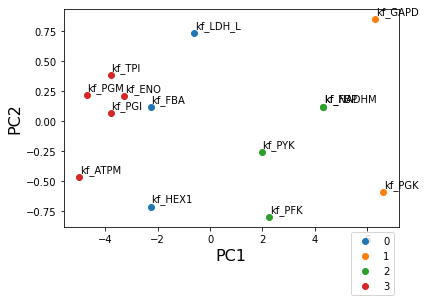

In [190]:
# ANSWER    

ax = PCA_cluster_plot(data_log.T, k10_labels)

make the plot above tooltip

In [170]:
data_norm = sklearn.preprocessing.normalize(data_log.T,norm='l2')
data_pc = PCA().fit_transform(data_norm.T)
data_pc = pd.DataFrame(data_pc, index = data_log.index)
plot_data = data_pc.iloc[:,0:2]
plot_data.columns = ["PC1", "PC2"]
plot_data["RXN"] = plot_data.index
alt.data_transformers.disable_max_rows()
fig = alt.Chart(plot_data).mark_circle(size= 100).encode(
    alt.X("PC1", axis=alt.Axis( tickCount=5)),
    alt.Y('PC2',axis=alt.Axis( tickCount=5), ), 

    alt.Color('RXN', scale=alt.Scale(scheme='turbo')), 
    tooltip=['RXN']
).properties(
    width=400,
    height=400).interactive()
fig

C:\Users\sicil\AppData\Local\Temp\ipykernel_18024\350331475.py:6 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


alt.Chart(...)

#### Creating elbow method to find optimal k clusters

In [191]:
# create a DataFrame to store all the clusters
k_range = range(2, 13)
elbow_df = pd.DataFrame(index = data_log.index, 
                        columns = k_range)

# compute the clusters at each k
for k in k_range:
    
    # repeat code from problem 1.2.1
    k_clusters = cluster.KMeans(n_clusters = k, random_state = 1)
    k_clusters = k_clusters.fit(data_log)
    
    # store in DataFrame
    elbow_df[k] = k_clusters.labels_

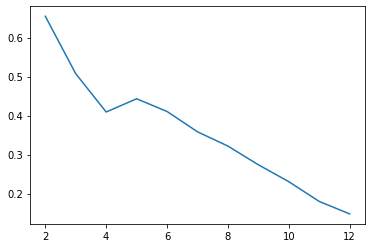

In [192]:
# compute the silhouette scores
k_silhouette = pd.Series(index = k_range, dtype=float)

for k in k_range:
    k_silhouette[k] = metrics.silhouette_score(data_log, elbow_df[k])
    
# plot
fig, ax = plt.subplots()
ax.plot(k_range, k_silhouette)

In [193]:
# output, look at plot, and pick the best k
# I think it is k = 9
# so I'll draw it on now
best_k = 4
ax.scatter(best_k, k_silhouette[best_k], color = 'r', s = 50)
ax.set_xlabel('K')
ax.set_ylabel('Silhouette Score')

print('Optimal K =', best_k)

Optimal K = 4


try with more sample size,
possibly could smooth out above graph,
could export percs df as csv so i dont have to rerun it


In [194]:
mean_silhouette = pd.Series(index = k_range, dtype=float)

# increase this number to make the curve smoother
# requires a lot of time to run
num_repeats = 10

for k in k_range:
    k_scs = []
    for i in range(num_repeats):
        # DO NOT specify a random state so we intentionally 
        # get different results
        k_clusters = cluster.KMeans(n_clusters = k)
        k_clusters = k_clusters.fit(percs_df.T)
        
        # add this silhouette score
        k_scs += [metrics.silhouette_score(percs_df.T, k_clusters.labels_)]
    
    # take the mean silhouette score
    mean_silhouette[k] = np.mean(k_scs)

Text(0.5, 1.0, 'Elbow curve')

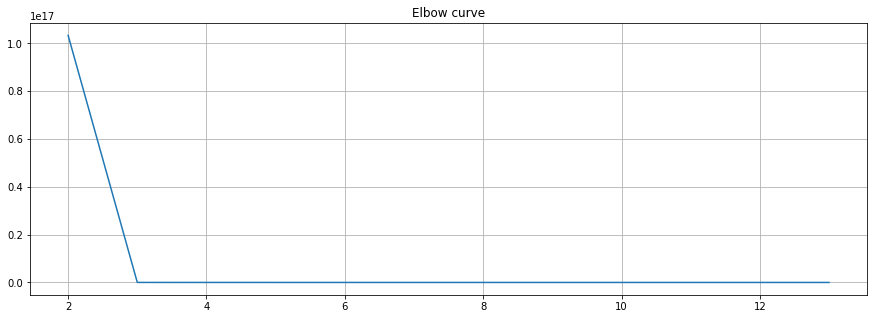

In [91]:
X = percs_df
distorsions = []
for k in range(2, 14):
    kmeans = cluster.KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 14), distorsions)
plt.grid(True)
plt.title('Elbow curve')

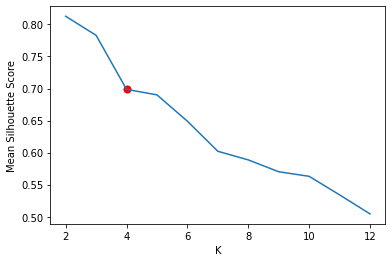

In [195]:
fig, ax = plt.subplots()
ax.plot(k_range, mean_silhouette)
ax.set_xlabel('K')
ax.set_ylabel('Mean Silhouette Score')


# this reduces our k slightly
best_k = 4
ax.scatter(best_k, mean_silhouette[best_k], color = 'r', s = 50)

In [93]:
import sklearn

In [201]:
# normalize the data
# data_norm = pd.DataFrame(stats.zscore(data_log, axis = 1), 
                        #  columns = data_log.columns, index = data_log.index)

data_norm = sklearn.preprocessing.normalize(percs_df,norm='l2')
data_norm= pd.DataFrame(data_norm)

In [203]:
data_norm = data_norm.T
data_norm.columns = [data_log.index]
# data_norm

In [204]:
data_norm

RXN,kf_HEX1,kf_PGI,kf_FBP,kf_PFK,kf_FBA,kf_TPI,kf_GAPD,kf_PGK,kf_PGM,kf_ENO,kf_PYK,kf_LDH_L,kf_ATPM,kf_NADHM
0,0.005413,0.035309,0.044677,0.002709,0.015660,0.033689,0.016960,0.005986,0.066580,0.073116,0.004595,0.008472,0.014494,0.044677
1,0.001142,0.003309,0.044677,0.000117,0.018188,0.004776,0.001904,0.010550,0.061342,0.065185,0.042742,0.002126,0.003740,0.044677
2,0.000789,0.003103,0.044677,0.010251,0.006800,0.015253,0.001017,0.009821,0.017259,0.019583,0.044344,0.001140,0.008212,0.044677
3,0.000536,0.038071,0.044677,0.004765,0.015559,0.019426,0.000699,0.000154,0.006218,0.005364,0.000349,0.000365,0.003109,0.044677
4,0.000611,0.037867,0.044677,0.003837,0.003033,0.011205,0.003189,0.001916,0.168319,0.144660,0.011423,0.009190,0.002641,0.044677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,0.111164,0.002274,0.044677,0.068044,0.077960,0.094999,0.005550,0.031280,0.011907,0.016280,0.012023,0.000331,0.115776,0.044677
497,0.061245,0.003865,0.044677,0.017571,0.098262,0.005195,0.000580,0.041116,0.008300,0.009134,0.028489,0.000659,0.045508,0.044677
498,0.013489,0.006920,0.044677,0.001795,0.111460,0.013083,0.000530,0.035636,0.008535,0.009428,0.015831,0.001005,0.016372,0.044677
499,0.014734,0.006311,0.044677,0.001163,0.047187,0.005316,0.000264,0.017911,0.155037,0.191127,0.010054,0.002223,0.004877,0.044677


In [205]:
data_vis = percs_df.T.melt()
data_vis.columns = ["RXN", "val"]
# data_vis

Overlaps of PERC values

In [206]:
data_vis

,RXN,val
0,kf_HEX1,21.084218
1,kf_HEX1,4.449128
2,kf_HEX1,3.072267
3,kf_HEX1,2.086218
4,kf_HEX1,2.380306
...,...,...
7009,kf_NADHM,100000.000000
7010,kf_NADHM,100000.000000
7011,kf_NADHM,100000.000000
7012,kf_NADHM,100000.000000


In [207]:
alt.data_transformers.disable_max_rows()
fig = alt.Chart(data_vis).mark_circle(size= 100).encode(
    alt.X("RXN", axis=alt.Axis( tickCount=5), scale=alt.Scale(type='log')),
    alt.Y('val',axis=alt.Axis( tickCount=5), 
    scale=alt.Scale(type='log')), 

    alt.Color('RXN', scale=alt.Scale(scheme='turbo')), 
    tooltip=['RXN', "val"]
).properties(
    width=400,
    height=400).interactive()
fig

alt.Chart(...)

In [100]:
data_log
data_norm_log = data_log.T
data_norm_log.columns = [data_log.index]
data_norm_log

RXN,kf_HEX1,kf_PGI,kf_FBP,kf_PFK,kf_FBA,kf_TPI,kf_GAPD,kf_PGK,kf_PGM,kf_ENO,kf_PYK,kf_LDH_L,kf_ATPM,kf_NADHM
OG,3.048525,1.815534,11.512925,8.114049,3.010977,1.913544,15.552142,14.787878,1.074574,3.058729,8.238734,5.163011,-0.816349,11.512925
No.0,1.492708,-0.551932,11.512925,4.969339,3.160617,-0.040014,13.365336,15.354599,0.992645,2.943911,10.468979,3.780224,-2.171135,11.512925
No.1,1.122416,-0.616141,11.512925,9.444851,2.176711,1.121134,12.737931,15.282947,-0.275470,1.741322,10.505787,3.157456,-1.384485,11.512925
No.2,0.735353,1.890848,11.512925,8.678773,3.004499,1.363002,12.363769,11.126300,-1.296423,0.446390,5.660275,2.018818,-2.355701,11.512925
No.3,0.867229,1.885473,11.512925,8.462043,1.369380,0.812765,13.881027,13.648631,2.002034,3.741064,9.149399,5.244287,-2.518893,11.512925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
No.495,6.070774,-0.926868,11.512925,11.337600,4.616044,2.950243,14.435045,16.441438,-0.646670,1.556588,9.200657,1.919209,1.261564,11.512925
No.496,5.474647,-0.396628,11.512925,9.983714,4.847485,0.043978,12.176166,16.714866,-1.007546,0.978678,10.063319,2.608489,0.327790,11.512925
No.497,3.961639,0.185851,11.512925,7.702229,4.973520,0.967657,12.086910,16.571829,-0.979669,1.010338,9.475751,3.030776,-0.694538,11.512925
No.498,4.049927,0.093692,11.512925,7.268466,4.113966,0.067116,11.390549,15.883881,1.919842,4.019619,9.021781,3.824968,-1.905616,11.512925


In [101]:
data_vis_log = data_norm_log.melt()
data_vis_log.columns = ["RXN", "val"]
data_vis_log

,RXN,val
0,kf_HEX1,3.048525
1,kf_HEX1,1.492708
2,kf_HEX1,1.122416
3,kf_HEX1,0.735353
4,kf_HEX1,0.867229
...,...,...
7009,kf_NADHM,11.512925
7010,kf_NADHM,11.512925
7011,kf_NADHM,11.512925
7012,kf_NADHM,11.512925


In [102]:
# Violin Plot of log transofmred data 
alt.data_transformers.disable_max_rows()
alt.Chart(data_vis_log).transform_density(
    'val',
    as_=['Value_column', 'density'],
    # extent=[-0.1, 0.1],
    groupby=['RXN']
).mark_area(orient='horizontal').encode(
    y=alt.Y(
        'Value_column:Q', scale=alt.Scale(type='log'),
                axis=alt.Axis(
            # labels=False, 
            # values=[0],
        grid=False,
         ticks=True)
        ),
    color='RXN:N',
    x=alt.X(
        'density:Q',
        stack='center',
        impute=None,
        title=None,
        axis=alt.Axis(labels=False, values=[0],grid=False, ticks=True),
    ),
    tooltip=['RXN:N', "Value_column:Q"], 
    column=alt.Column(
        'RXN:N',
        header=alt.Header(
            titleOrient='bottom',
            labelOrient='bottom',
            labelPadding=0,
        ),
    )
).properties(
    width=50
).configure_facet(
    spacing=0
).configure_view(
    stroke=None
).interactive()

alt.Chart(...)

In [104]:
# Violin Plot of percs distribution without log tranforming
alt.data_transformers.disable_max_rows()
alt.Chart(data_vis).transform_density(
    'val',
    as_=['Value_column', 'density'],    
    groupby=['RXN']
    ).mark_area(orient='horizontal').encode(
    y=alt.Y('Value_column:Q',axis=alt.Axis(grid=False,ticks=True)),
    color='RXN:N',
    x=alt.X('density:Q', stack='center',impute=None,
        title=None,
        axis=alt.Axis(labels=False, values=[0],grid=False, ticks=True)),
        tooltip=['RXN:N', "Value_column:Q"], 
    column=alt.Column(
        'RXN:N',header=alt.Header(
            titleOrient='bottom',
            labelOrient='bottom',
            labelPadding=0))
).properties(
    width=50).configure_facet(spacing=0).configure_view(stroke=None).interactive()

alt.Chart(...)

Make a violin plot for above^

could also log base 10 transform above df and then seeing dsitrubution


In [111]:
pca = decomposition.PCA().fit(data_norm.T)

# get the two important matrices & label them in pandas
pc_genes = pd.DataFrame(pca.components_,
                        columns = data_norm.index)
pc_samples = pd.DataFrame(pca.transform(data_norm.T),
                          index = data_norm.columns)

# get the explained variance, which will be useful later
exp_var = pca.explained_variance_ratio_

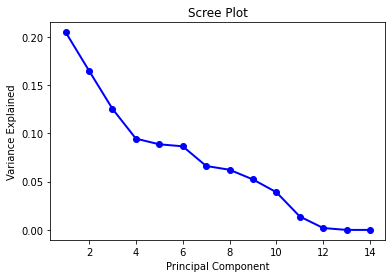

In [112]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [113]:
# get the cumulative variance
cum_var = exp_var.cumsum()

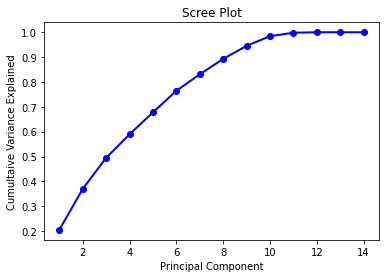

In [114]:
plt.plot(PC_values, cum_var, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Cumultaive Variance Explained')
plt.show()

Components to capture 80% of variance:  7


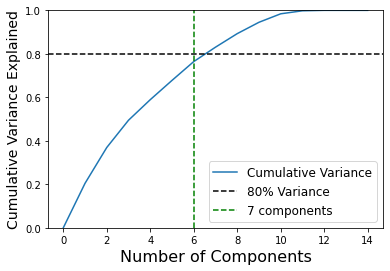

In [115]:
# find the number of components
index_80 = sum(cum_var <= 0.8)

# indices are zero-indexed, so the total number is one more than this
print('Components to capture 80% of variance: ', index_80+1)

# add a zero at the start so the plot extends all the way down
cum_var_plot = [0] + list(cum_var)

# plot
fig, ax = plt.subplots()
ax.plot(range(len(cum_var_plot)), cum_var_plot, label = 'Cumulative Variance')

# add some lines to illustrate the question
ax.axhline(0.8, color = 'k', linestyle = '--', label = '80% Variance')
ax.axvline(index_80, color = 'g', linestyle = '--', label = str(index_80+1)+ ' components')

# limit the y axes
ax.set_ylim([0, 1])

# axes labels and legend
ax.set_xlabel('Number of Components', fontsize = 16)
ax.set_ylabel('Cumulative Variance Explained', fontsize = 14)
_ = ax.legend(fontsize = 12)

In [108]:
cum_var

array([0.2073009 , 0.38012533, 0.51938724, 0.61335231, 0.69863539,
       0.77544084, 0.84388543, 0.90251017, 0.94913195, 0.98528185,
       0.99820461, 1.        , 1.        , 1.        ])

In [147]:
pca_red = decomposition.PCA(n_components = 4).fit(data_norm.T)
scores_pca = pca_red.transform(data_norm.T)

k means clustering with PCA

In [148]:
kmeans = cluster.KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
kmeans = kmeans.fit(scores_pca)

In [149]:
data_norm

RXN,kf_HEX1,kf_PGI,kf_FBP,kf_PFK,kf_FBA,kf_TPI,kf_GAPD,kf_PGK,kf_PGM,kf_ENO,kf_PYK,kf_LDH_L,kf_ATPM,kf_NADHM
0,0.005413,0.035309,0.044677,0.002709,0.015660,0.033689,0.016960,0.005986,0.066580,0.073116,0.004595,0.008472,0.014494,0.044677
1,0.001142,0.003309,0.044677,0.000117,0.018188,0.004776,0.001904,0.010550,0.061342,0.065185,0.042742,0.002126,0.003740,0.044677
2,0.000789,0.003103,0.044677,0.010251,0.006800,0.015253,0.001017,0.009821,0.017259,0.019583,0.044344,0.001140,0.008212,0.044677
3,0.000536,0.038071,0.044677,0.004765,0.015559,0.019426,0.000699,0.000154,0.006218,0.005364,0.000349,0.000365,0.003109,0.044677
4,0.000611,0.037867,0.044677,0.003837,0.003033,0.011205,0.003189,0.001916,0.168319,0.144660,0.011423,0.009190,0.002641,0.044677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,0.111164,0.002274,0.044677,0.068044,0.077960,0.094999,0.005550,0.031280,0.011907,0.016280,0.012023,0.000331,0.115776,0.044677
497,0.061245,0.003865,0.044677,0.017571,0.098262,0.005195,0.000580,0.041116,0.008300,0.009134,0.028489,0.000659,0.045508,0.044677
498,0.013489,0.006920,0.044677,0.001795,0.111460,0.013083,0.000530,0.035636,0.008535,0.009428,0.015831,0.001005,0.016372,0.044677
499,0.014734,0.006311,0.044677,0.001163,0.047187,0.005316,0.000264,0.017911,0.155037,0.191127,0.010054,0.002223,0.004877,0.044677


In [151]:
df_segm_pca_kmeans = pd.concat([data_norm, pd.DataFrame(scores_pca)], axis =1)
df_segm_pca_kmeans.columns.values[-4:] = ["Component 1", "Component 2", "Component 3", "Component 4"]

df_segm_pca_kmeans["segment kmeansPCA"] = kmeans.labels_


ValueError: Length of values (14) does not match length of index (501)

In [152]:
df_segm_pca_kmeans["Segment"] =  df_segm_pca_kmeans["segment kmeansPCA"].map({0:'1st', 
1:"2nd",
2: "3rd",
3: "4th",
4:"5th",
5:"6th",
6:"7th",
7:"8th",
8:"9th",
9:"10th",
10:"11th"})

KeyError: 'segment kmeansPCA'

In [153]:
x_axis = df_segm_pca_kmeans["Component 2"]
y_axis = df_segm_pca_kmeans["Component 1"]

In [154]:
plt.figure(figsize= (10,8))
sns.scatterplot(x_axis, y_axis, hue = df_segm_pca_kmeans["Segment"], 
# palette = ['g', 'r', 'c', 'm',]
)
plt.title("CLusters by PCA components")
plt.show()

KeyError: 'Segment'

<Figure size 720x576 with 0 Axes>

look at eigenvalues, how many evals are needed for this much variance

Scree plot


keep the number of PCA componenets bewteen 3 and 5 tops
incerase samples, drive down the componenets

after the PCA--> elbow plot
k emans clustering--> elbow plot



In [155]:
from sklearn.preprocessing import StandardScaler

In [156]:
df_st =  StandardScaler().fit_transform(percs_df.T)  
pd.DataFrame(df_st, columns=percs_df.T.columns).head(2)

RXN,kf_HEX1,kf_PGI,kf_FBP,kf_PFK,kf_FBA,kf_TPI,kf_GAPD,kf_PGK,kf_PGM,kf_ENO,kf_PYK,kf_LDH_L,kf_ATPM,kf_NADHM
0,-0.299399,0.302574,0.0,-0.492267,-0.321150,0.324985,-0.033363,-0.310312,1.133938,1.305511,-0.388708,-0.363220,-0.403897,0.0
1,-0.403501,-0.544962,0.0,-0.558822,-0.250022,-0.406715,-0.402840,-0.197962,0.996150,1.096585,0.567400,-0.527642,-0.715863,0.0


In [157]:
pca_out = PCA().fit(df_st)
pca_out.explained_variance_ratio_
np.cumsum(pca_out.explained_variance_ratio_)
loadings = pca_out.components_
num_pc = pca_out.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = percs_df.T.columns.values
loadings_df = loadings_df.set_index('variable')
loadings_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
variable,,,,,,,,,,,,,,
kf_HEX1,4.123100e-01,-2.360790e-02,1.122864e-01,-3.279919e-01,-3.723968e-02,-1.709122e-01,8.439683e-02,-4.938242e-01,6.412713e-01,7.969043e-02,-9.952761e-02,-1.371495e-02,-9.222831e-17,0.0
kf_PGI,1.121631e-01,-3.919812e-02,-1.064020e-01,5.768695e-01,2.458620e-02,6.837972e-01,2.160971e-01,-1.623260e-01,2.896357e-01,6.543146e-03,1.288421e-01,4.518149e-03,9.436175e-17,0.0
kf_FBP,1.110223e-16,2.289835e-16,-2.220446e-16,3.330669e-16,2.220446e-16,1.110223e-16,-8.326673e-17,-2.636780e-16,1.110223e-16,4.163336e-17,-6.106227e-16,2.775558e-17,1.000000e+00,0.0
kf_PFK,5.381037e-01,-8.273631e-02,6.300184e-03,2.130223e-01,8.513677e-02,2.502934e-02,-1.109578e-01,-1.267631e-01,-3.970768e-01,-1.523042e-01,-6.638599e-01,-1.868514e-02,-3.173208e-16,0.0
kf_FBA,1.060974e-01,-1.178374e-02,3.116005e-02,5.268901e-01,-4.159944e-01,-5.667447e-01,3.760381e-01,2.296855e-01,1.460566e-01,-9.793007e-04,-1.205055e-02,1.143529e-02,-5.416895e-17,0.0
kf_TPI,-9.292832e-02,5.498742e-02,2.694132e-01,1.018491e-01,7.878584e-01,-2.067719e-01,4.553659e-01,-4.429040e-02,-1.116522e-02,-1.765531e-01,2.651819e-02,-2.428752e-02,-2.000829e-18,0.0
kf_GAPD,-1.728051e-02,2.678515e-02,6.972514e-01,1.061821e-01,-5.753575e-02,9.227653e-02,-4.299947e-02,-3.946514e-02,-1.487469e-01,6.804860e-01,-3.314225e-02,5.732174e-03,-1.949703e-17,0.0
kf_PGK,4.080711e-01,9.219866e-02,-3.089397e-02,-1.360092e-01,2.299325e-01,1.257644e-01,-7.024280e-02,7.798261e-01,3.047948e-01,1.673035e-01,-4.758391e-02,-2.492889e-02,1.229743e-16,0.0
kf_PGM,2.495145e-02,6.592386e-01,-9.530791e-02,1.260052e-01,2.030970e-02,-6.780685e-02,-1.418562e-01,-1.090426e-01,-9.180153e-03,5.395700e-02,3.515849e-02,-7.060917e-01,-1.507384e-18,0.0


In [158]:
import seaborn as sns
import matplotlib.pyplot as plt

Generated correlation matrix plot for loadings

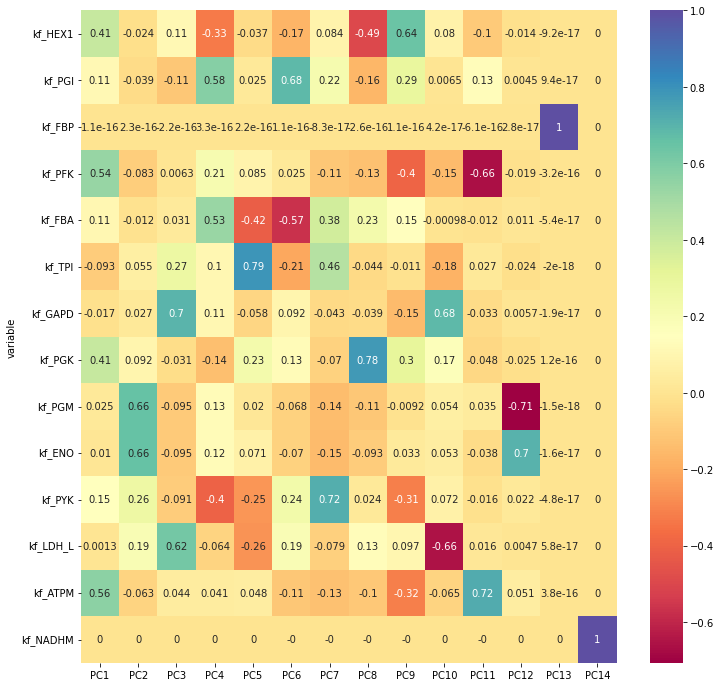

In [159]:
plt.figure(figsize= (12,12))
ax = sns.heatmap(loadings_df, annot=True, cmap='Spectral')

plt.show()

In [104]:
image_heatmap = os.path.join(data_dir,"heatmap_image.png")
plt.savefig(image_heatmap)
# percs_df.to_csv(csv_percs)

<Figure size 432x288 with 0 Axes>

Next steps:
possibly removing NADHM, add sinks and sources
see differences bw PC 2/3

change conc flexbilties
variation, see convergence

potentially see sample sizes, and 
make sure fluxes and conc units align (b4 presnetnig)




In [ ]:
liver.reactions.PGK

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(loadings_df, annot=True, cmap='Spectral')
plt.show()

In [ ]:
# ANSWER
pc1 = pc_genes.loc[0].to_frame('weight')
pc2 = pc_genes.loc[1].to_frame('weight')

# need the absolute values to sort by
pc1['abs_weight'] = pc1.weight.abs()
pc2['abs_weight'] = pc2.weight.abs()

# sort and keep only the top 5
pc1 = pc1.sort_values('abs_weight', ascending = False).iloc[0:5]
pc2 = pc2.sort_values('abs_weight', ascending = False).iloc[0:5]

# concatenate the gene table info
# pc1 = pd.concat([pc1, gene_table.loc[pc1.index]], axis = 1)
# pc2 = pd.concat([pc2, gene_table.loc[pc2.index]], axis = 1)
fig, ax = plt.subplots(figsize = (10, 10))

# scatter the sample loadings
ax.scatter(pc_samples[0], pc_samples[1])

# add the labels, use the exp_var
ax.set_xlabel('PC1 (%.1f%%)'%(exp_var[0]*100), fontsize = 18)
ax.set_ylabel('PC2 (%.1f%%)'%(exp_var[1]*100), fontsize = 18)

# add the arrows
# begin by getting the genes from 1.3.1
# arrows_to_make = pc1.index.append(pc2.index)

# # this would get crowded, so remove specific genes that overlap
# arrows_to_make = arrows_to_make.drop(['b3361','b3519', 'b0948', 'b3411'])

# arrow length variable extends arrows to help in interpreting the plot
# text_scale determines how far text labels are from arrow tips (1 = on top of them)
arrow_length = 500
text_scale = 1.3

# the place the arrows start is up to you, so you can move it out of the way
start1 = 25
start2 = 40

# loop through each gene and add its arrow
# for g in arrows_to_make:
#     # directions in PC1 and 2
#     g_weight_pc1 = pc_genes.loc[0, g]
#     g_weight_pc2 = pc_genes.loc[1, g]
    
#     # lengthen arrow by a constant factor
#     g_weight_pc1 = g_weight_pc1 * arrow_length
#     g_weight_pc2 = g_weight_pc2 * arrow_length
    
#     # add the arrow
#     ax.arrow(start1, start2, g_weight_pc1, g_weight_pc2, head_width = 2)
    
#     # add the gene's name to the plot
#     g_name = gene_table.gene_name[g]
#     ax.text(start1 + (text_scale * g_weight_pc1),
#             start2 + (text_scale * g_weight_pc2), 
#             g_name)

looking for correlation, 
larger- negatively
smaller- positively
90- indepenedt
so therefore looking at how much weight each perc has
can we see if specific percs 
is there a specific perc(s) that can be attributed to a specific component
look at atatching loadings on PC1, theire wieghts


Set-up plots, to identify what the dots are 
make moseouver using altair
3d--> plotly

make something to pull up omcponenets?

colour the points absed on subsystem

increase the number of sample points

### Next Steps:
1) looking at overlaps of Perc values
2) 

1) Plot a 45 deg line on above graph, make a line for 0,0


In [ ]:
liver.reactions.EX_glc__D_c.Keq = 1
liver.reactions.EX_h_c.Keq = 1 
liver.reactions.EX_h2o_c.Keq = 1 
liver.reactions.EX_pi_c.Keq = 1 
liver.reactions.EX_pyr_c.Keq = 1 
liver.reactions.EX_lac__L_c.Keq = 1 
# liver.reactions.EX_nadh_c.Keq = 1 
# liver.reactions.EX_nad_c.Keq = 1 

In [ ]:
liver.boundary_conditions['glc__D_b']=0.010482807 ##M ## initial condition of the metabolite in the model
liver.boundary_conditions['h2o_b']=1 ##M
liver.boundary_conditions['h_b']=0.0064 ##M
liver.boundary_conditions['pi_b']=0.010482807 ##M
liver.boundary_conditions['pyr_b']=0.00048 ##M
liver.boundary_conditions['nadh_b']=4.63542E-06
liver.boundary_conditions['nad_b']=0.00182531
liver.boundary_conditions['lac__L_b']=0.003261838

In [ ]:
Boundary= [
             "EX_glc__D_c", 
            "EX_h_c", 
            "EX_h2o_c",
            'EX_pyr_c',
            'EX_pi_c',
    "ATPM",
    
#     'EX_nad_c',
    "EX_lac__L_c"
]
for x in Boundary:
    a=liver.reactions.get_by_id(x)
    a.kf=1e6

In [ ]:
liver.calculate_PERCs(fluxes={
                r: v for r, v in liver.steady_state_fluxes.items()
                if not (r.boundary  
#                         or r== liver.reactions.GLCter or r== glycogenolysis.reactions.PIter
#                                or r== glycogenolysis.reactions.G6Pter or r== glycogenolysis.reactions.PIt or 
#                                 r== glycogenolysis.reactions.PYRt2m or 
#                                 r== glycogenolysis.reactions.L_LACt2r or 
#                                 r== glycogenolysis.reactions.PYRt2 or 
#                                 r== glycogenolysis.reactions.PEPtm or r== glycogenolysis.reactions.GLCt1 
#                                 or r== glycogenolysis.reactions.Ht
                       )
},
                      update_reactions=True)

print("Forward Rate Constants\n----------------------")
for reaction in liver.reactions:
    print("{0}: {1:.6f}".format(reaction.kf_str, reaction.kf))

In [ ]:
#Function to add underscore in front of metabolite identifiers which start with a number
## fix this only after getting Keq from equlibrator because bigg doesn't have _13dpg for example
def prefix_number_id(id_str):
    """Prefix identifiers that start with numbers."""
    if re.match(r"^\d", id_str):
        id_str = "_" + id_str
    return id_str

In [ ]:
#Loop to edit the names using "prefix_number_id" function defined earlier
for metabolite in liver.metabolites:
    new_met_id = prefix_number_id(metabolite.id)
    metabolite.id = new_met_id
liver.repair()

In [ ]:
qcqa_model(liver, parameters=True, concentrations=True,
           fluxes=True, superfluous=True, elemental=True)

In [ ]:
# Setup simulation object
simG=Simulation(liver, verbose=True)
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol, flux_sol = simG.simulate(liver, time=(0, 1e8))
# Quickly render and display time profiles
conc_sol.view_time_profile()

In [ ]:
json_save = os.path.join(model_dir,liver.id + ".json")
json.save_json_model(model=liver, filename=json_save)